In [3]:
import os
import glob
import numpy as np
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import song_utils
import time
import seaborn as sns

In [3]:
'/run/user/1000/gvfs/smb-share:server=cup,share=murthy/Kyle/data/edna/control'

shape of x: (6591, 300)
shape of y: (6591,)
time to run code =  97.98573343100725


In [19]:
r2_score = {}
accuracy = {}
logloss = {}
filterShapes = {}
filterNorms = {}
start = time.perf_counter()
x, y = glm.load_design(exptList, 'mLS', 300, mfDist_thresh=10)
end = time.perf_counter()
print("time to run code = ", end-start)
# results = glm_utils.pcor(x, y, 300)
# print(np.mean(results['f1_score']))

shape of x: (6591, 300)
shape of y: (6591,)
time to run code =  534.7767808479994


In [2]:
results = pd.read_csv(r'results/results2/results.csv')

In [3]:
order = list(results.groupby('feature').agg("mean").sort_values('pCor', ascending=False).index)

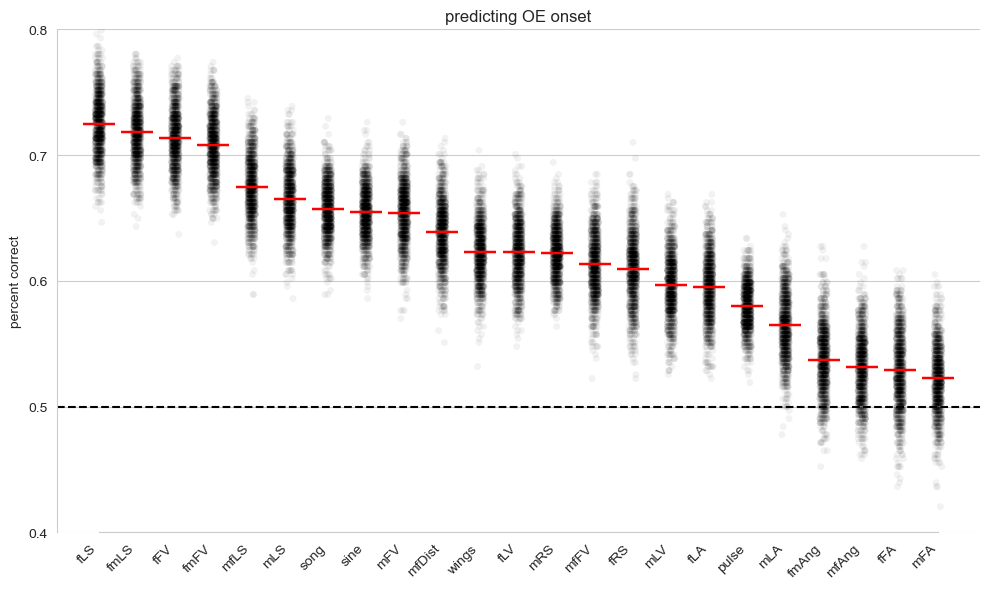

In [4]:
plt.figure(figsize=(10,6))
sns.stripplot(x = 'feature', y='pCor', data=results, order=order, color='k', alpha=.05)
# sns.boxplot(x='feature', y='pCor', data=results, order=order,
#             showmeans=True, meanline=False,
#             meanprops={'color': 'r', 'ls': '-', 'lw':2},
#             whiskerprops={'visible':False},
#             zorder=10,
#             showfliers=False,
#             showbox=False,
#             showcaps=False)
sns.scatterplot(data=results.groupby('feature').agg("mean").sort_values('pCor', ascending=False), x='feature', y='pCor', zorder=10, color='r',marker='_', s=500)
plt.axhline(y=.5, ls='--', color='k')
plt.yticks(np.arange(0.4, 0.81, .1))
plt.xticks(rotation='45', ha='right')
plt.title("predicting OE onset")
plt.xlabel("")
plt.ylabel('percent correct')
sns.despine(trim=True)
plt.tight_layout()
# plt.savefig(r'results/results1/percent_correct.pdf')

## Scratch

In [42]:
ftr = 'mLS'
accuracy[ftr] = np.array(results['fraction_correct'])/2
# logloss[ftr] = results['logloss']
filterShapes[ftr] = results['filtershape']
# filterNorms[ftr] = results['filter_norms']
# f1[ftr] = results['f1_score']

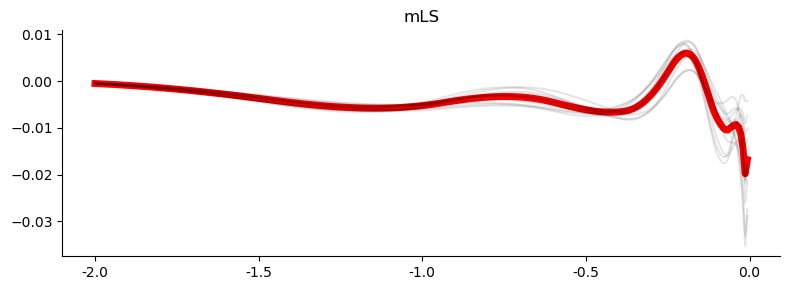

In [70]:
plt.figure(figsize=(8,3))
plt.title('mLS')
plt.plot(np.mean(filterShapes['mLS'], axis=0), c='r', lw=5)
plt.plot(filterShapes['mLS'].T, alpha=0.1, c='k')
xticks = np.arange(0,filterShapes['mLS'].shape[-1]+1, 75)
xlabels = np.arange(-filterShapes['mLS'].shape[-1]/150,0.1, .5)
plt.xticks(xticks, xlabels)
sns.despine()
plt.tight_layout()

In [39]:
df = pd.DataFrame(columns=['ftr', 'pcor'])
for pcor, f1, ll, fs, fn in zip(results['fraction_correct'], results


,0,1,2,3,4,5,6,7,8,9,10,11
0,mfDist,0.684713,0.707006,0.643312,0.659236,0.66242,0.633758,0.630573,0.671975,0.678344,0.646497,0.671975
1,mLS,0.342357,0.353503,0.321656,0.329618,0.33121,0.316879,0.315287,0.335987,0.339172,0.323248,0.335987


In [21]:
df = pd.DataFrame.from_dict(accuracy)

In [30]:
df = pd.DataFrame(accuracy.items(), columns=['ftr', 'pcor'])

ValueError: setting an array element with a sequence.

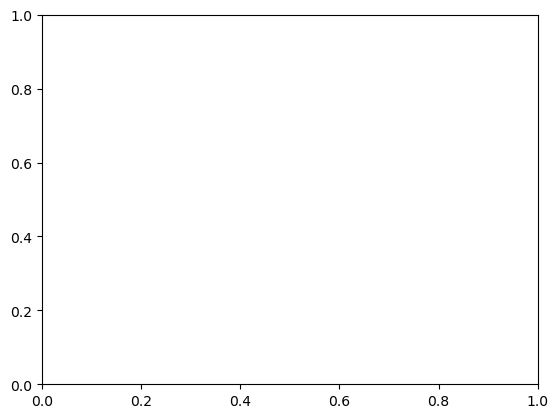

In [32]:
sns.stripplot(x='ftr', y='pcor', data=df)

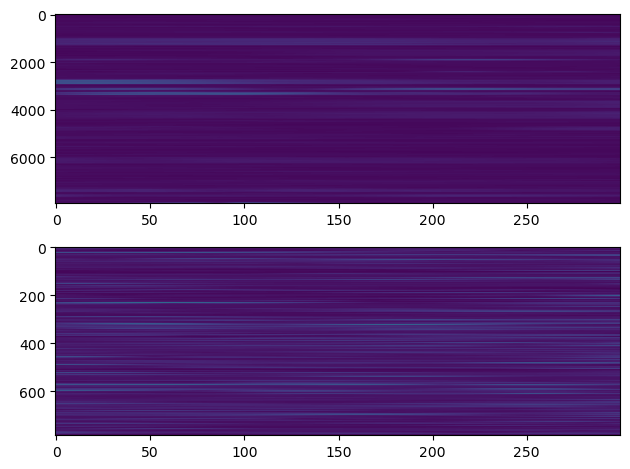

In [5]:
fig, axs = plt.subplots(2)
axs[0].imshow(x[np.where(y==0)[0]], aspect='auto')
axs[1].imshow(x[np.where(y==1)[0]], aspect='auto')
plt.tight_layout()

In [2]:
import bases
import sklearn
from sklearn.metrics import log_loss, r2_score
from sklearn.preprocessing import StandardScaler

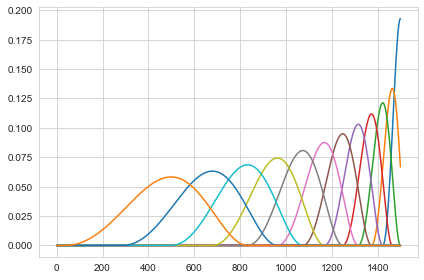

In [9]:
window = 1500
# B = bases.raised_cosine(0, 12, [0,220], 75, window)
B = bases.raised_cosine(0, 12, [0, 1000], 200, window)
plt.plot(B)
plt.tight_layout()

In [13]:
from glm import load_feature, design
from scipy.ndimage import gaussian_filter1d

def load_design(exptList, ftr, window, mfDist_thresh=10, fmAng_thresh=60, px2mm=30):
    fullDesignMatrix = []
    fullOutput = []
    for exptDir in exptList:
        # initialize feature and Zscore it
        fly = os.path.basename(exptDir)
        ftrfile = os.path.join(exptDir, fly + '_smoothed.h5')
        songftrs = os.path.join(exptDir, fly + '_song.h5')
        if fly == '220809_162800_16276625_rig2_1':  # weird tracks
            continue
        if ftr == 'wings':
            wingL = load_feature(ftrfile, 'wingML', fill=True)
            wingR = load_feature(ftrfile, 'wingMR', fill=True)
            wings = np.stack((wingL, wingR)).T
            feat = abs(np.max(wings, axis=1))
            feat = gaussian_filter1d(feat, sigma=2)
            feat = zscore(feat, nan_policy='omit')
        elif ftr == 'song':
            pulse = load_feature(songftrs, 'pulseStEn')
            sine = load_feature(songftrs, 'sineStEn')
            frame_at_sample = load_feature(ftrfile, 'frame_at_sample')
            if pulse.any():
                pulse = frame_at_sample[pulse].astype(int)
            if sine.any():
                sine = frame_at_sample[sine].astype(int)
            feat = np.zeros(int(frame_at_sample[-1]))
            for st, en in pulse:
                feat[st:en] = 1
            for st, en in sine:
                feat[st:en] = 2

        elif ftr != 'pulse' and ftr != 'sine':
            feat = load_feature(ftrfile, ftr, fill=True)
            feat = gaussian_filter1d(feat, sigma=2)
            feat = zscore(feat, nan_policy='omit')
            if np.isnan(feat).any():
                continue

        else:  # feature = 'sine' or 'pulse'
            ftrname = ftr + 'StEn'
            feature = load_feature(songftrs, ftrname)
            frame_at_sample = load_feature(ftrfile, 'frame_at_sample')
            if feature.any():
                feature = frame_at_sample[feature].astype(int)
            feat = np.zeros(int(frame_at_sample[-1]))
            for st, en in feature:
                feat[st:en] = 1

        x, y = design(ftrfile, feat, window, mfDist_thresh, fmAng_thresh, px2mm)

        fullDesignMatrix.append(x)
        fullOutput.append(y)
        # import pdb; pdb.set_trace();

    fullDesignMatrix = np.array([trace for array in fullDesignMatrix for trace in array])
    fullOutput = np.array([output for array in fullOutput for output in array])

    print(f"shape of x: {fullDesignMatrix.shape}")
    print(f"shape of y: {fullOutput.shape}")

    return fullDesignMatrix, fullOutput

In [14]:
cup = song_utils.getParentDirectory('cup')
tigress = song_utils.getParentDirectory('tigress')

exptfolder = 'blind'
exptList = glob.glob(os.path.join(cup, rf'Kyle/data/edna/{exptfolder}/**'))

savepath = os.path.join(tigress, r'Kyle/code/edna')
print(fr"Saving results to : /results/{exptfolder}")

if not os.path.exists(os.path.join(savepath, f'results/{exptfolder}')):
    os.makedirs(os.path.join(savepath, f'results/{exptfolder}'))

ftrList = [
    "song", "pulse", "sine"
]

# random.seed(15)

results = pd.DataFrame(columns=['feature', 'pCor', 'f1_score', 'logloss', 'filterNorms', 'deviance'])
saveFile = os.path.join(savepath, rf'results/{exptfolder}/results.csv')
if os.path.exists(saveFile):
    print("results CSV exits: double check all features are there")

for ftr in ftrList:
    print("working on {}".format(ftr))

    x, y = load_design(exptList, ftr, 300, mfDist_thresh=10)
    # fracCorr, f1value, lloss, fshapes, fnorms, dev = pcor(x, y, 300)

    print("plotting {} filters".format(ftr))
    # filterSavePath = os.path.join(savepath, f'results/{exptfolder}/{ftr}_filters.png')
    # plot_filters(fshapes, ftr, filterSavePath)

    # for pc, f1, ll, fn, d in zip(fracCorr, f1value, lloss, fnorms, dev):
    #     results.loc[len(results.index)] = [ftr, pc, f1, ll, fn, d]
    # print("done with {}\n".format(ftr))

print("saving final dataframe\n\n\n")

print("All done")

Saving results to : /results/blind
results CSV exits: double check all features are there
working on song
shape of x: (5684, 300)
shape of y: (5684,)
plotting song filters
working on pulse
shape of x: (5709, 300)
shape of y: (5709,)
plotting pulse filters
working on sine
shape of x: (5700, 300)
shape of y: (5700,)
plotting sine filters
saving final dataframe



All done


In [26]:
pd.read_csv(saveFile, index_col=0)

,feature,pCor,f1_score,logloss,filterNorms,deviance
0,mfDist,0.615,0.654709,0.656832,0.346452,262.732835
1,mfDist,0.670,0.707965,0.644829,0.258842,257.931521
2,mfDist,0.630,0.678261,0.647891,0.312340,259.156566
3,mfDist,0.655,0.684932,0.645547,0.332188,258.218773
4,mfDist,0.580,0.631579,0.682619,0.253096,273.047795
...,...,...,...,...,...,...
20015,wings,0.680,0.623529,0.616851,0.123544,246.740279
20016,wings,0.650,0.578313,0.623980,0.111580,249.592039
20017,wings,0.640,0.576471,0.682235,0.141463,272.893928
20018,wings,0.675,0.619883,0.615317,0.124592,246.126719


In [20]:
results['feature'].unique()

array(['mfDist', 'mFV', 'fFV', 'mFA', 'fFA', 'mLV', 'fLV', 'mLS', 'fLS',
       'mLA', 'fLA', 'mRS', 'fRS', 'mfAng', 'fmAng', 'mfFV', 'fmFV',
       'mfLS', 'fmLS', 'wings'], dtype=object)

In [4]:
mani_Groups = [
    "AD_control_BD",
    "blind",
    "blind_deaf",
    "deaf",
]

geno_groups = [
    "AD_control",
    "LC31_Kir",
    "vpoEN_Kir"
]

In [5]:
allResults_mani = pd.DataFrame(columns=['group','feature', 'pCor', 'f1_score', 'logloss'])
for group in mani_Groups:
    results = pd.read_csv(rf'results/{group}/results.csv', usecols=['feature', 'pCor', 'f1_score', 'logloss'])
    results['group']=group
    allResults_mani = pd.concat([allResults_mani, results], ignore_index=True)

allResults_geno = pd.DataFrame(columns=['group','feature', 'pCor', 'f1_score', 'logloss'])
for group in geno_groups:
    results = pd.read_csv(rf'results/{group}/results.csv', usecols=['feature', 'pCor', 'f1_score', 'logloss'])
    results['group']=group
    allResults_geno = pd.concat([allResults_geno, results], ignore_index=True)

In [14]:
excludeftrs = ['wings', 'fmLS', 'fmFV', 'mfLS', 'mfFV']
maniResults_simple = allResults_mani[~allResults_mani['feature'].isin(excludeftrs)]

In [15]:
order = maniResults_simple[maniResults_simple['group']=='AD_control_BD'].groupby('feature').mean().sort_values('pCor', ascending=False)
order = list(order.index)

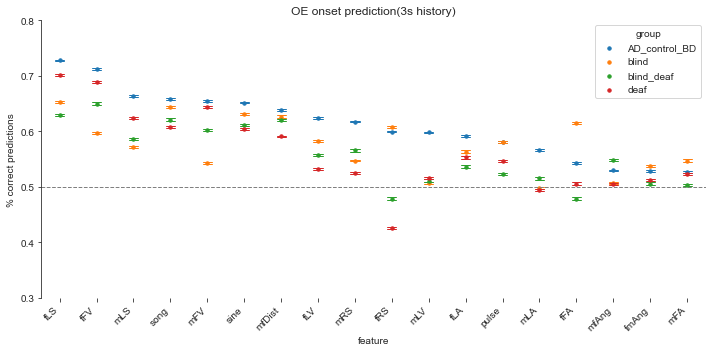

In [17]:
sns.set_style('ticks')
plt.figure(figsize=(10,5))
sns.pointplot(data=maniResults_simple, x='feature', y='pCor', hue='group',
              dodge=False, join=False, order=order,
              scale=0.5, errorbar=('ci', 95), capsize=0.25, errwidth=1)
plt.ylim(0.3,0.8)
plt.axhline(y=0.5, ls='--', c='gray', lw=1)
plt.xticks(rotation=45, ha='right')
plt.ylabel('% correct predictions')
plt.title('OE onset prediction(3s history)')
sns.despine(bottom=True, trim=True)

plt.tight_layout()
plt.savefig('results/OE_onset_prediction_manipulated_3s.png')

In [19]:
genoResults_simple = allResults_geno[~allResults_geno['feature'].isin(excludeftrs)]

order = genoResults_simple[genoResults_simple['group']=='AD_control'].groupby('feature').mean().sort_values('pCor', ascending=False)
order = list(order.index)

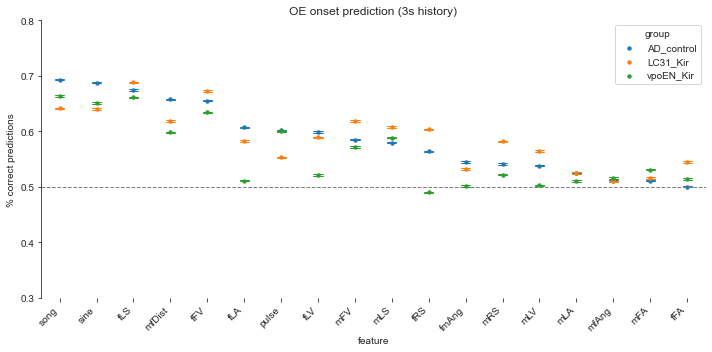

In [21]:
sns.set_style('ticks')
plt.figure(figsize=(10,5))
sns.pointplot(data=allResults_geno, x='feature', y='pCor', hue='group',
              dodge=False, join=False, order=order,
              scale=0.5, errorbar=('ci', 95), capsize=0.25, errwidth=1)
plt.ylim(0.3,0.8)
plt.axhline(y=0.5, ls='--', c='gray', lw=1)
plt.xticks(rotation=45, ha='right')
plt.ylabel('% correct predictions')
plt.title('OE onset prediction (3s history)')
sns.despine(bottom=True, trim=True)

plt.tight_layout()
plt.savefig('results/OE_onset_prediction_silenced_3s.png')
